In [1]:
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import glob

In [2]:
# import tcpdump files
tcp = pd.DataFrame(index=[], columns=[])
files = glob.glob('darpa_tcpdump/*')
for file in files:
    tcp1 = pd.read_csv(file, delim_whitespace=True, header=None)
    tcp = tcp.append(tcp1, ignore_index=True)

In [3]:
tcp = tcp.iloc[:,[1,2,5,6,9]]
tcp.columns = ['date', 'time', 'source', 'destination', 'anomaly']

In [4]:
tcp

,date,time,source,destination,anomaly
0,07/24/1998,08:00:06,1039,53,0
1,07/24/1998,08:00:06,53,53,0
2,07/24/1998,08:00:06,53,53,0
3,07/24/1998,08:00:27,1024,25,0
4,07/24/1998,08:00:34,1026,25,0
5,07/24/1998,08:00:38,53,53,0
6,07/24/1998,08:00:38,1118,53,0
7,07/24/1998,08:00:38,53,53,0
8,07/24/1998,08:00:43,1120,53,0
9,07/24/1998,08:00:43,53,53,0


In [5]:
# exclude collapsing data
tcp = tcp[tcp.date != '07/32/1998']

# acquire datetime information
tcp['date_time'] = tcp['date'] + '/' + tcp['time']
tcp = tcp.drop('date', axis=1)
tcp = tcp.drop('time', axis=1)
tcp['date_time'] = pd.to_datetime(tcp['date_time'], format='%m/%d/%Y/%H:%M:%S')

C:\Users\toshi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [6]:
# calculate how many hours passed since the initial time
initial_time = tcp['date_time'].min()
tcp['date_time'] = tcp['date_time'] - initial_time
tcp['hours_past'] = tcp['date_time'].dt.days * 24 + tcp['date_time'].dt.seconds//3600
tcp = tcp.drop('date_time', axis=1)
tcp = tcp.sort_values('hours_past')

In [7]:
graphs = tcp.loc[:, ['source', 'destination', 'hours_past']]
graphs = graphs.values

In [8]:
class SpotLight:
    def __init__(self, graphs):
        '''
        input should be Nx3 array. (N: number of total edges)
        first column: source node
        second column: destination node
        third column: timestamp
        '''
        self.graphs = graphs
        self.timestamps = np.unique(graphs[:,2])
        self.num_of_timestamp = self.timestamps.shape[0]

    def sketch(self, K=50, p=0.2, q=0.2):
        '''
        K: number of subgraphs
        p: source sampling probability
        q: destination sampling probability
        '''
        sketched_vectors = np.empty((0, K), int)
        for i in tqdm(range (self.num_of_timestamp)):
            sketched_vector = np.empty((0, K), int)
            graph = self.graphs[self.graphs[:, 2] == (self.timestamps[i])]
            self.source_nodes = np.unique(graph[:,0]).reshape((-1, 1))
            self.dest_nodes = np.unique(graph[:,1]).reshape((-1, 1))
            self.hashing(K, p, q)
            for j in range(graph.shape[0]):
                source = graph[j, 0]
                dest = graph[j, 1]
                sources_are_in_subgraphs = (self.subgraphs_source[self.subgraphs_source[:, 0] == source])[:,1:]
                dests_are_in_subgraphs = (self.subgraphs_dest[self.subgraphs_dest[:, 0] == dest])[:,1:]
                sketched_vector = np.append(sketched_vector, sources_are_in_subgraphs * dests_are_in_subgraphs, axis=0)
            sketched_vector = np.sum(sketched_vector, axis=0).reshape((1, K))
            sketched_vectors = np.append(sketched_vectors, sketched_vector, axis=0)
        return sketched_vectors
        

    def hashing(self, K, p, q):
        self.subgraphs_source = np.random.choice([0,1], [self.source_nodes.shape[0], K], p = [1-p, p])
        self.subgraphs_source = np.concatenate((self.source_nodes, self.subgraphs_source), axis=1)
        self.subgraphs_dest = np.random.choice([0,1], [self.dest_nodes.shape[0], K], p = [1-q, q])
        self.subgraphs_dest = np.concatenate((self.dest_nodes, self.subgraphs_dest), axis=1)

In [9]:
# sketching tcodump data to spotlight space.
SL = SpotLight(graphs)
v_g = SL.sketch(50, 0.2, 0.2)

100%|██████████████████████████████████████████████████████████████████████████████| 206/206 [4:50:46<00:00, 84.69s/it]


In [10]:
v_g.shape

(206, 50)

In [11]:
# anomaly detection based on Isolation Forest
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators=100, max_samples=100, contamination=0.9)
clf.fit(v_g)
detected = clf.score_samples(v_g)
detected = detected * -1

C:\Users\toshi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


In [12]:
# groupby timestamp, timestamps which contain more than 1000 anomalous communication are anomalous timestamps
truth = tcp.groupby('hours_past').sum()
truth = ((truth.anomaly.values > 1000)*1)

In [13]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, thresholds = precision_recall_curve(truth, detected)
print('Area Under Curve:', auc(recall, precision))

Area Under Curve: 0.7975259981357161


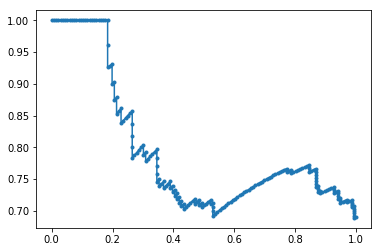

In [14]:
# draw recall precision curve
from matplotlib import pyplot
%matplotlib inline
pyplot.plot(recall, precision, marker='.')